In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from sqlalchemy import create_engine
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import sklearn.metrics
# import getpass


In [3]:
# password = getpass.getpass()
# !RSYNC_PASSWORD={password} rsync -avPR -e 'ssh -p 23263' mathias@gate08.aime.info:/home/mathias/workspace/pia-ic-web/./results.db ~/Downloads
# del password
!rsync pia@vxpod01.cp.jku.at:/var/home/pia/pia_persistent/results.db ~/Downloads

/tmp/ipykernel_4613/129380051.py:50: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_4613/129380051.py:50: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_4613/129380051.py:50: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


               user_id
unique users        29
total samples      173
          expertise
<lambda>          6
<lambda>         23


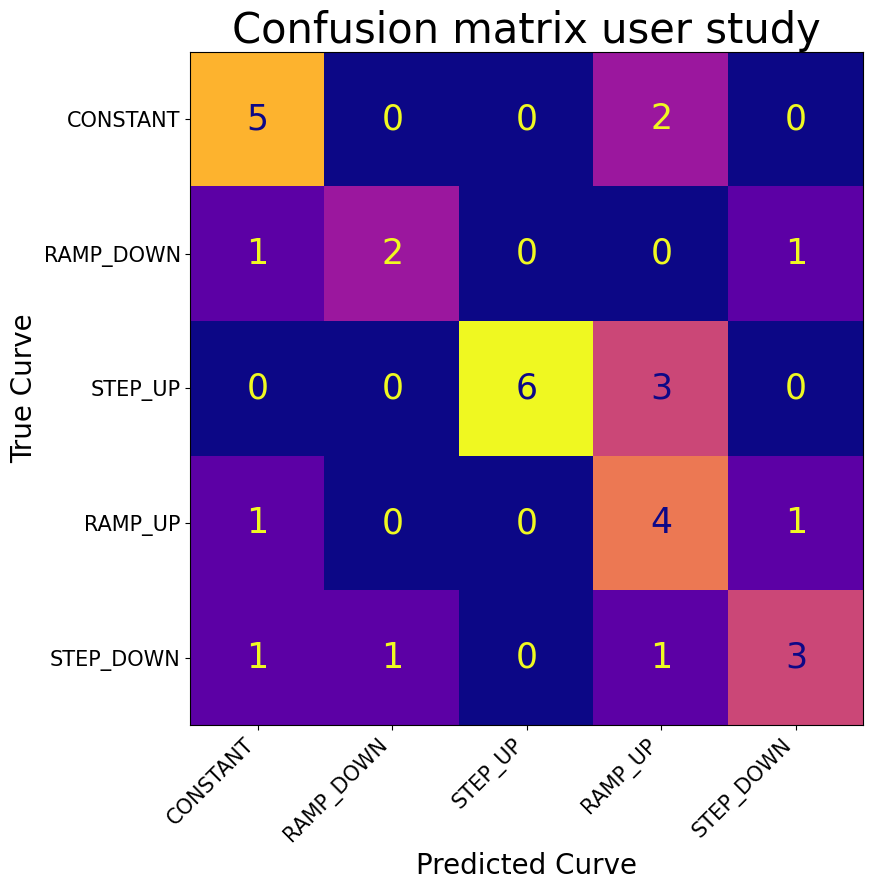

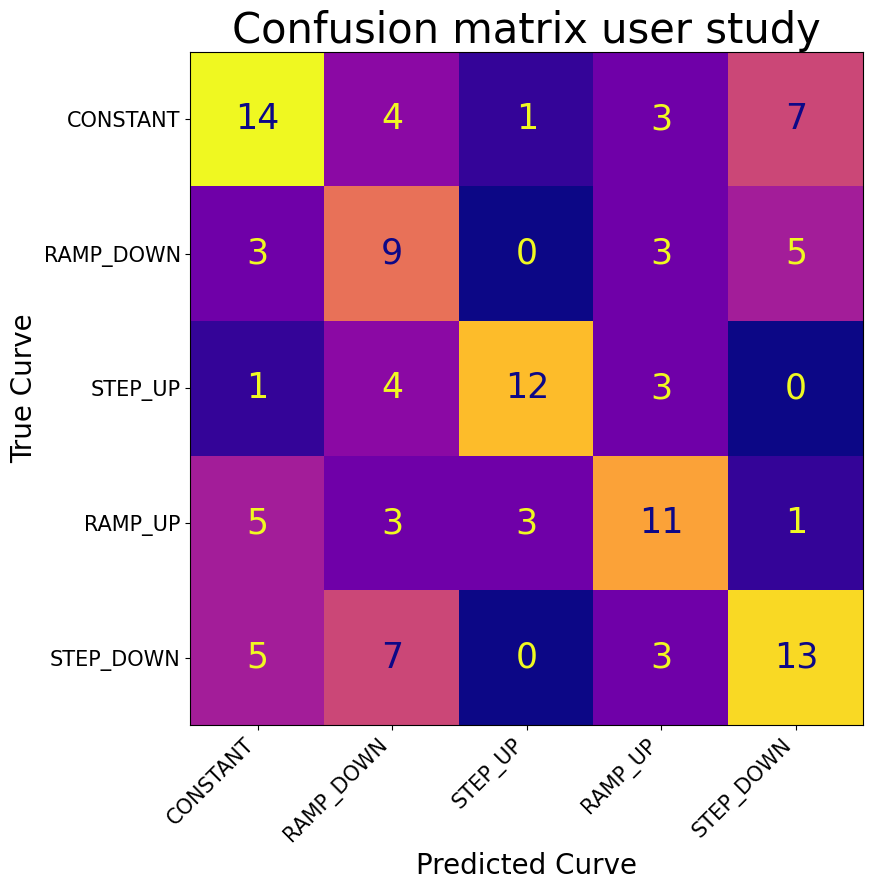

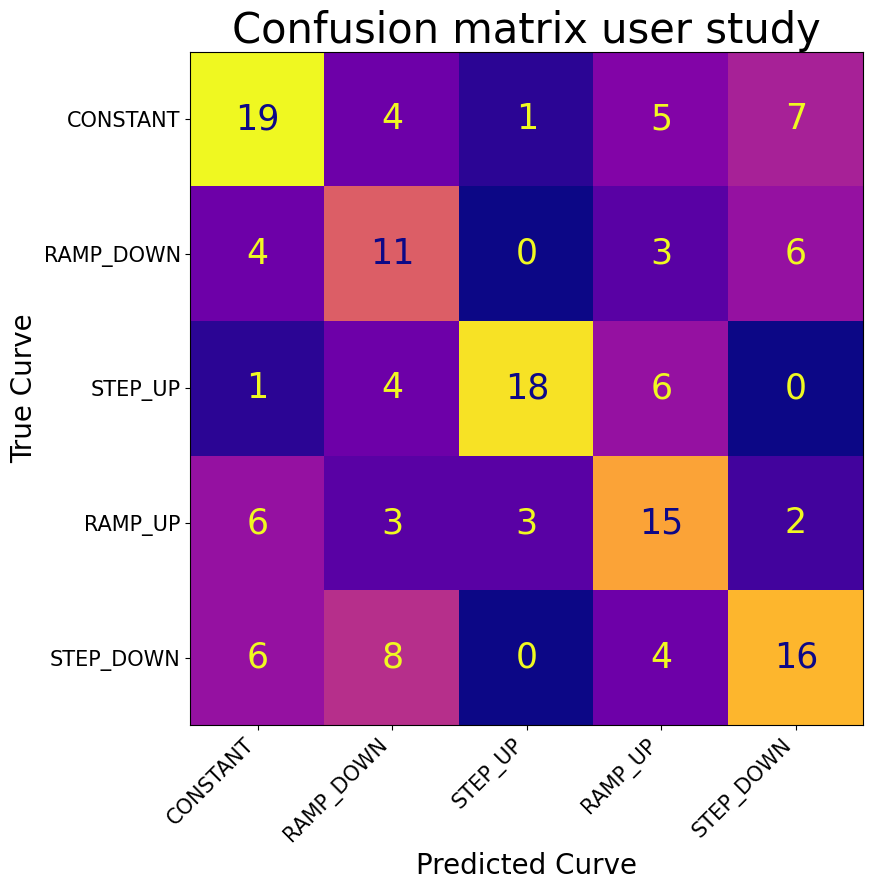

In [7]:
db = '/home/mathias/Downloads/results.db'
# db = '/home/mathias/devel/python/pia-ic-web/pia-ic-web/results.db'
with create_engine(f'sqlite:///{db}').connect() as conn: 
    result = pd.read_sql_table('result', conn, index_col='id')
    sample_collection = pd.read_sql_table('sample_collection', conn)
    user = pd.read_sql_table('user', conn, index_col='id')
    user = user[user.index.isin(result.user_id.unique())]
    result = result.merge(user, left_on='user_id', right_index=True, how='left')
exp_mapper = {'a6aa5f7b2689124d92900e130182eebe0394953f773fcfec9b9e9e1466e792da': 'CONSTANT',
'72a43dd9af72e7ccd05ba5ecc8e1fd8e535846e8388e735e0c5e349e7540c30b': 'RAMP_DOWN',
'd30e81355ddfe0c3bc1975e719f3457053510c566c1e49e2494bae4dbfddc66a': 'STEP_UP',
'd52c4aa9a59ad9edb6c51cc4032185f21d1ea1cec9224e7ee636a971ec8432aa': 'RAMP_UP',
'5866e160e605939fa3643f4d30e00db67e4a8b6a4f1e1b22434182868a7052ca': 'STEP_DOWN'}
# labels = result.exp.apply(lambda x: exp_mapper[x.exp])
labels = list(exp_mapper.values())
precs = []
groups = ['rookie', 'expert', 'all']
for title in groups:

    if title == 'rookie':
        result_by_user = result[result.expertise == 0]
    elif title == 'expert':
        result_by_user = result[result.expertise == 1]
    else:
        result_by_user = result
    result_gen = result_by_user[result_by_user.correct_exp != '8be2450735d84156c7a8b0c22e611ca531bf536ab6f8e71ccc50c8817b9cc67a']

    # result_gen = result_gen[result_gen.user_id == 4]

    # normalize='true' #  -> recall in diag
    # normalize='pred' # -> precision in diag
    normalize = None
    cm = confusion_matrix(y_true=result_gen.correct_exp.apply(lambda x: exp_mapper[x]), y_pred=result_gen.selected_exp.apply(lambda x: exp_mapper[x]), labels=labels, normalize=normalize)
    fig, ax = plt.subplots(
        figsize=(9.1,9)
    )
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

    disp.plot(cmap='plasma', ax=ax, colorbar=False ,text_kw={'size': 25}
              #, values_format='.2f'
              )
    ax.set_title("Confusion matrix user study", fontsize=30)
    # disp.plot()
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=15)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=15)
    ax.set_xlabel('Predicted Curve', fontsize=20)  
    ax.set_ylabel('True Curve', fontsize=20)  
    fig.tight_layout()
    fig.savefig(f'cm_{title}.pdf')
    fig.show()
    real_mask = result.exp_type == '0'
    real = result_by_user.loc[real_mask]
    drawn = result_by_user.loc[~real_mask]
    # prec_real = (real.correct_piece == real.selected_piece).mean()
    # prec = prec_real / (prec_real + fps)
    # prec_drawn = result_by_user.loc[~real_mask].apply(lambda result: result.correct_exp == result.selected_exp, axis=1).mean()
    # hehe = sklearn.metrics.precision_score(y_true=real.correct_piece, y_pred=real.selected_piece, average='micro')
    # hoho = sklearn.metrics.precision_score(y_true=drawn.correct_exp, y_pred=drawn.selected_exp, average='micro')
    # precs.append((prec_real, prec_drawn))
    # f1 = 2 * tps / (2 * tps + len(real) - tps)

    # drawn = result_by_user[~real_mask]
    # print(title, 'real', round(prec_real , 2), 'drawn', round(prec_drawn,2), hehe, hoho)

print(result.agg({'user_id': [lambda x: len(x.unique()), 'count']}).rename({'<lambda>': 'unique users', 'count': 'total samples'}))
print(user.agg({'expertise': [(lambda x: (x==0).sum()), lambda x: (x==1).sum()]}).rename({0: 'rookies', '<lambda_1>': 'experts'}))


In [28]:
labels

['constantlow', 'rampdown2', 'squareoffset', 'rampup2', 'square']

In [56]:
result_gen.correct_exp.apply(lambda x: exp_mapper[x]).unique()

array(['constantlow', 'squareoffset', 'rampup2', 'rampdown2', 'square'],
      dtype=object)

In [54]:
sklearn.metrics.precision_score(y_true=result_gen.correct_exp.apply(lambda x: exp_mapper[x]), y_pred=result_gen.selected_exp.apply(lambda x: exp_mapper[x]),average=None, labels=[0])

/home/mathias/miniconda3/envs/pia-web/lib/python3.8/site-packages/numpy/lib/arraysetops.py:729: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/home/mathias/miniconda3/envs/pia-web/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([0.])

In [203]:


prec = sklearn.metrics.precision_score(y_true=result_gen.correct_exp.apply(lambda x: exp_mapper[x]), y_pred=result_gen.selected_exp.apply(lambda x: exp_mapper[x]),average=None, labels=labels)
rec = sklearn.metrics.recall_score(y_true=result_gen.correct_exp.apply(lambda x: exp_mapper[x]), y_pred=result_gen.selected_exp.apply(lambda x: exp_mapper[x]),average=None, labels=labels)
f1 = sklearn.metrics.f1_score(y_true=result_gen.correct_exp.apply(lambda x: exp_mapper[x]), y_pred=result_gen.selected_exp.apply(lambda x: exp_mapper[x]),average=None, labels=labels)
counts_correct = pd.value_counts(result_gen.correct_exp.apply(lambda x: exp_mapper[x]))
counts_predicted = pd.value_counts(result_gen.selected_exp.apply(lambda x: exp_mapper[x]))

## add agg for total , drawn, real
prec_all =  [sklearn.metrics.precision_score(y_true=drawn.correct_exp, y_pred=drawn.selected_exp, average='micro'),
               sklearn.metrics.precision_score(y_true=real.correct_piece, y_pred=real.selected_piece, average='micro')]
rec_all = [sklearn.metrics.recall_score(y_true=drawn.correct_exp, y_pred=drawn.selected_exp, average='micro'),
               sklearn.metrics.recall_score(y_true=real.correct_piece, y_pred=real.selected_piece, average='micro')]
f1_all =  [sklearn.metrics.f1_score(y_true=drawn.correct_exp, y_pred=drawn.selected_exp, average='micro'),
               sklearn.metrics.f1_score(y_true=real.correct_piece, y_pred=real.selected_piece, average='micro')]
counts_all = predictions_all = [len(drawn), len(real)]
df = pd.DataFrame({'prec': prec.tolist()+prec_all, 'rec': rec.tolist() + rec_all,'f1': f1.tolist() + f1_all, '\#True': counts_correct.tolist() + counts_all, '\#Pred':counts_predicted.tolist()+predictions_all}, index=labels + ['drawn', 'real'])
style = df.T.style.format(decimal='.', thousands=',', precision=2)
style.to_latex('user_study.tex')
style
# f1, prec

,CONSTANT,RAMP_DOWN,STEP_UP,RAMP_UP,STEP_DOWN,drawn,real
prec,0.53,0.37,0.82,0.45,0.52,0.52,0.71
rec,0.53,0.46,0.62,0.52,0.47,0.52,0.71
f1,0.53,0.41,0.71,0.48,0.49,0.52,0.71
\#True,36.00,34.00,29.00,29.00,24.00,152.00,21.00
\#Pred,36.00,33.00,31.00,30.00,22.00,152.00,21.00


In [8]:
import numpy as np

In [10]:
sklearn.metrics.f1_score(y_true=np.random.randint(5,size=(50000)), y_pred=np.random.randint(5,size=(50000)), labels=np.arange(5), average=None)

array([0.1954714 , 0.19614116, 0.20145884, 0.19942561, 0.20517173])